In [1]:
import os
# В вектор-ых машинах мы учим представленние фичей - можем обобщить

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np

from implicit.als import AlternatingLeastSquares

from rectools.metrics import Precision, Recall, MAP, calc_metrics
from rectools.models import PopularModel, RandomModel, ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel


import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from pathlib import Path
import typing as tp
from tqdm import tqdm

from lightfm import LightFM

from implicit.bpr import BayesianPersonalizedRanking

from implicit.lmf import LogisticMatrixFactorization

In [4]:
!pwd

/home/iuliiasolomennikova/!!!RecSysService/notebooks


In [5]:
DATA_PATH = Path("kion_train")


# LOAD DATA

In [6]:
%%time
users = pd.read_csv(DATA_PATH / 'users.csv')
items = pd.read_csv(DATA_PATH / 'items.csv')
interactions = pd.read_csv(DATA_PATH / 'interactions.csv')

CPU times: user 4.86 s, sys: 1.43 s, total: 6.28 s
Wall time: 6.43 s


# EDA

### Users

In [7]:
print(f"Всего уникальных пользователей: {users[Columns.User].nunique():,}")

Всего уникальных пользователей: 840,197


In [8]:
def plot_normalized_barh_chart(
    dataframe: pd.DataFrame,
    column_name: str,
    title: str,
    figsize: tp.Tuple[int, int] = (12, 7),
    annotate_chart: bool = True,
    xlabel: tp.Optional[str] = None,
    ylabel: tp.Optional[str] = None,
) -> plt.Axes.axes:
    ax = (
        dataframe[column_name]
        .value_counts(dropna=False, normalize=True)
        .sort_index()
        .plot(
            kind='barh',
            grid=True,
            title=title,
            figsize=figsize,
            xlabel=xlabel,
            ylabel=ylabel,
        )
    )

    if annotate_chart:
        for bars in ax.containers:
            ax.bar_label(bars, labels=[f'{x:.1%}' for x in bars.datavalues])

In [9]:
users['sex'] = users['sex'].map({'Ж': 1, 'М': 0})

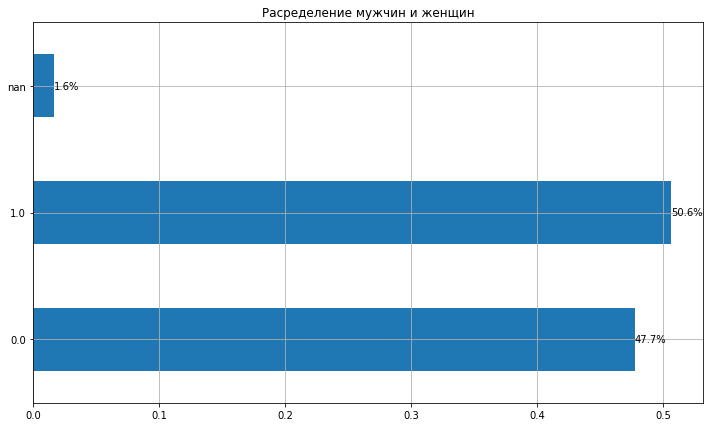

In [10]:
plot_normalized_barh_chart(users, 'sex', 'Расределение мужчин и женщин')

In [11]:
age_category = pd.CategoricalDtype(
    categories=[
        'age_18_24',
        'age_25_34',
        'age_35_44',
        'age_45_54',
        'age_55_64',
        'age_65_inf',
    ],
    ordered=True,
)

In [12]:
users['age'] = users['age'].astype(age_category)

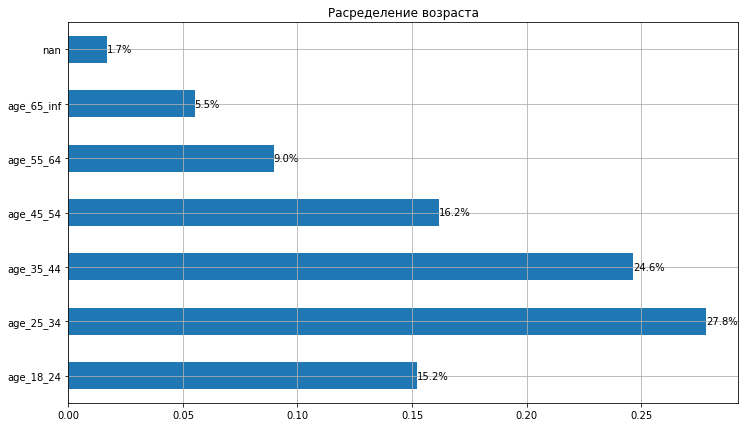

In [14]:
plot_normalized_barh_chart(users, 'age', 'Расределение возраста')

In [15]:
income_category = pd.CategoricalDtype(
    categories=[
        'income_0_20',
        'income_20_40',
        'income_40_60',
        'income_60_90',
        'income_90_150',
        'income_150_inf',
    ],
    ordered=True,
)

In [16]:
users['income'] = users['income'].astype(income_category)

In [17]:
users

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,0.0,1
1,962099,age_18_24,income_20_40,0.0,0
2,1047345,age_45_54,income_40_60,1.0,0
3,721985,age_45_54,income_20_40,1.0,0
4,704055,age_35_44,income_60_90,1.0,0
...,...,...,...,...,...
840192,339025,age_65_inf,income_0_20,1.0,0
840193,983617,age_18_24,income_20_40,1.0,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,1.0,0


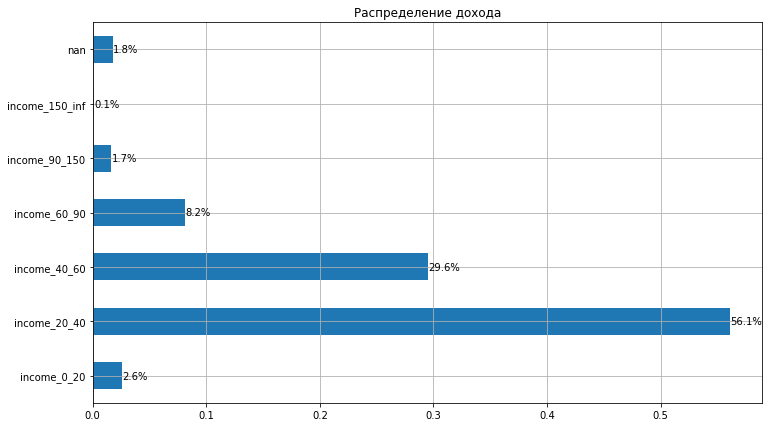

In [19]:
plot_normalized_barh_chart(users, 'income', 'Распределение дохода')

### Items

In [20]:
print(f"Всего уникальных items: {items[Columns.Item].nunique():,}")

Всего уникальных items: 15,963


In [21]:
YEAR_FROM = 1990
STEP_SIZE = 5
bins = [year for year in range(YEAR_FROM, int(items['release_year'].max()) + STEP_SIZE, STEP_SIZE)]

In [35]:
bins = [int(items['release_year'].min())] + bins

In [22]:
items['year_bin'] = pd.cut(items['release_year'],
                           bins=bins, include_lowest=True)

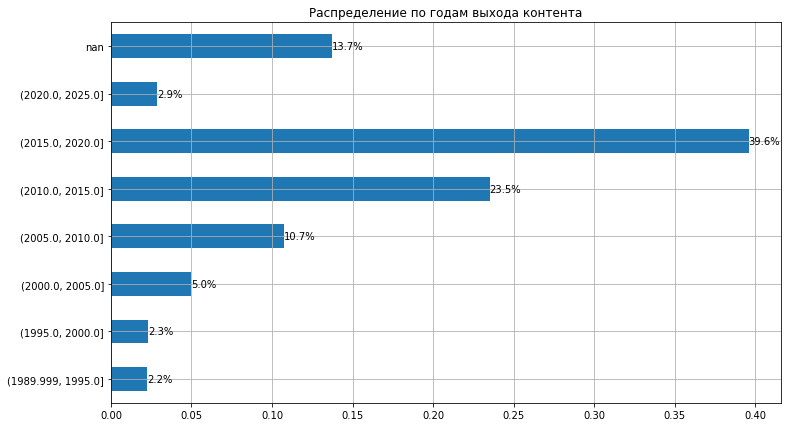

In [23]:
plot_normalized_barh_chart(items, 'year_bin', 'Распределение по годам выхода контента')

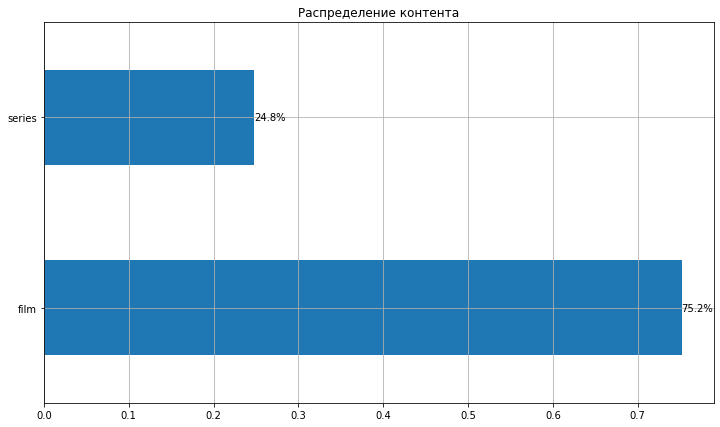

In [24]:
plot_normalized_barh_chart(items, 'content_type', 'Распределение контента')

### Interactions

In [25]:
print('Кол-во уникальных пользователей и items в interactions')
interactions[Columns.UserItem].nunique()

Кол-во уникальных пользователей и items в interactions


user_id    962179
item_id     15706
dtype: int64

In [26]:
Columns.Datetime = 'last_watch_dt'

In [27]:
interactions.drop(interactions[interactions[Columns.Datetime].str.len() != 10].index, inplace=True)

In [28]:
interactions[Columns.Datetime].str.len().value_counts()

10    5476251
Name: last_watch_dt, dtype: int64

In [29]:
interactions[Columns.Datetime].min(), interactions[Columns.Datetime].max()

('2021-03-13', '2021-08-22')

# Train/Test split

In [30]:
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime], format='%Y-%m-%d')

In [31]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


In [32]:
max_date = interactions[Columns.Datetime].max()

Видим, что есть какие-то выбросы, пока на не обращаем внимание, посмотрим...

In [33]:
interactions['total_dur'].describe(percentiles=[.01,.1,.5,.9,.99]).round(2)

count     5476251.00
mean         8295.49
std         48567.99
min             1.00
1%              3.00
10%            42.00
50%          2898.00
90%         15112.00
99%         90083.00
max      80411672.00
Name: total_dur, dtype: float64

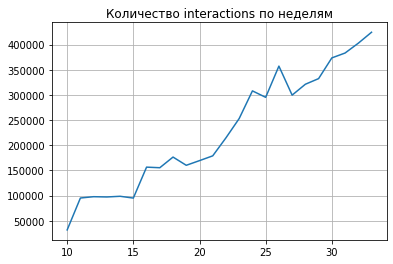

In [35]:
(
    interactions[Columns.Datetime].dt.isocalendar().week
    .value_counts(sort=False)
    .sort_index()
    .plot(grid=True, title='Количество interactions по неделям')
);

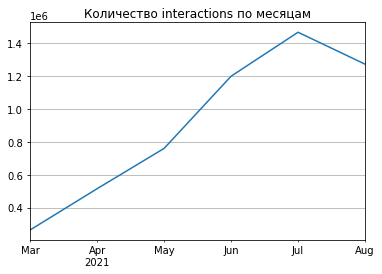

In [36]:
(
    interactions[Columns.Datetime].dt.to_period('M')
    .value_counts(sort=False)
    .sort_index()
    .plot(grid=True, title='Количество interactions по месяцам')
);

In [37]:
(interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)).sum()

490982

In [38]:
interactions['watched_pct'].describe().round()

count    5475423.0
mean          46.0
std           42.0
min            0.0
25%            4.0
50%           32.0
75%          100.0
max          100.0
Name: watched_pct, dtype: float64

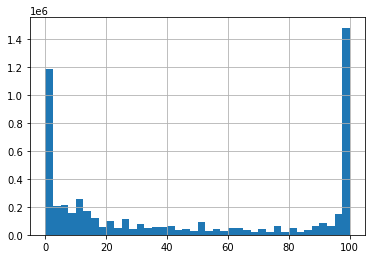

In [40]:
interactions['watched_pct'].hist(bins=40);

In [41]:
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 15, 3, 1)

In [42]:
interactions[Columns.Weight].value_counts(normalize=True)

3    0.591957
1    0.408043
Name: weight, dtype: float64

In [43]:
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4985269, 6)
test: (490982, 6)


In [44]:
train.drop(train.query("total_dur < 300").index, inplace=True)

In [45]:
# отфильтруем холодных пользователей из теста
cold_users = set(test[Columns.User]) - set(train[Columns.User])

In [46]:
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

# MODELS

In [47]:
K_RECOS = 10
RANDOM_STATE = 42
NUM_THREADS = 16
N_FACTORS = (32, 64, 128, 160)
ITERATIONS = (15, 20)

In [48]:
metrics_name = {
    'Precision': Precision,
    'Recall': Recall,
    'MAP': MAP,
}

metrics = {}
for metric_name, metric in metrics_name.items():
    for k in range(1, 11):
        metrics[f'{metric_name}@{k}'] = metric(k=k)

In [49]:
dataset = Dataset.construct(
        interactions_df=train
    )

In [50]:
list_metrics_combined = {}

for components in [15,16,17]:
    for losses in ['logistic', 'bpr', 'warp']: # реализуем разные лоссы
        for rho in [0.91,0.92,0.93]:
            for lr in [0.05,0.005]:
                epsilon = 3

                lightfm = LightFMWrapperModel(
                        model = LightFM(
                            no_components = components,
                            learning_schedule = 'adadelta',
                            loss = losses,
                            rho = rho,
                            epsilon = epsilon,
                            learning_rate = lr,
                            random_state = RANDOM_STATE
                        )
                    )

                lightfm.fit(dataset)

                recs = lightfm.recommend(
                    users=test[Columns.User].unique(),
                    dataset=dataset,
                    k=K_RECOS,
                    filter_viewed=True,
                )

                metric_values = calc_metrics(metrics, recs, test, train)

                list_metrics_combined[f"{components}_{losses}_{rho}_{lr}"] = metric_values
                print(f"MAP@10({components}_{losses}_{rho}_{lr}) = {metric_values['MAP@10']}")

                

MAP@10(15_logistic_0.91_0.05) = 0.07402269682912495
MAP@10(15_logistic_0.91_0.005) = 0.07402269682912495
MAP@10(15_logistic_0.92_0.05) = 0.07402269682912495
MAP@10(15_logistic_0.92_0.005) = 0.07402269682912495
MAP@10(15_logistic_0.93_0.05) = 0.0740218749172061
MAP@10(15_logistic_0.93_0.005) = 0.0740218749172061
MAP@10(15_bpr_0.91_0.05) = 0.002291666030057197
MAP@10(15_bpr_0.91_0.005) = 0.002291666030057197
MAP@10(15_bpr_0.92_0.05) = 0.003915245243147005
MAP@10(15_bpr_0.92_0.005) = 0.003915245243147005
MAP@10(15_bpr_0.93_0.05) = 0.003471645467915098
MAP@10(15_bpr_0.93_0.005) = 0.003471645467915098
MAP@10(15_warp_0.91_0.05) = 0.06013888203476336
MAP@10(15_warp_0.91_0.005) = 0.06013888203476336
MAP@10(15_warp_0.92_0.05) = 0.05989028973791324
MAP@10(15_warp_0.92_0.005) = 0.05989028973791324
MAP@10(15_warp_0.93_0.05) = 0.05823024577137994
MAP@10(15_warp_0.93_0.005) = 0.05823024577137994
MAP@10(16_logistic_0.91_0.05) = 0.07401729487606827
MAP@10(16_logistic_0.91_0.005) = 0.07401729487606827


In [51]:
for k,v in list_metrics_combined.items():
    print(k,v['MAP@10'])

15_logistic_0.91_0.05 0.07402269682912495
15_logistic_0.91_0.005 0.07402269682912495
15_logistic_0.92_0.05 0.07402269682912495
15_logistic_0.92_0.005 0.07402269682912495
15_logistic_0.93_0.05 0.0740218749172061
15_logistic_0.93_0.005 0.0740218749172061
15_bpr_0.91_0.05 0.002291666030057197
15_bpr_0.91_0.005 0.002291666030057197
15_bpr_0.92_0.05 0.003915245243147005
15_bpr_0.92_0.005 0.003915245243147005
15_bpr_0.93_0.05 0.003471645467915098
15_bpr_0.93_0.005 0.003471645467915098
15_warp_0.91_0.05 0.06013888203476336
15_warp_0.91_0.005 0.06013888203476336
15_warp_0.92_0.05 0.05989028973791324
15_warp_0.92_0.005 0.05989028973791324
15_warp_0.93_0.05 0.05823024577137994
15_warp_0.93_0.005 0.05823024577137994
16_logistic_0.91_0.05 0.07401729487606827
16_logistic_0.91_0.005 0.07401729487606827
16_logistic_0.92_0.05 0.07401729487606827
16_logistic_0.92_0.005 0.07401729487606827
16_logistic_0.93_0.05 0.07401729487606827
16_logistic_0.93_0.005 0.07401729487606827
16_bpr_0.91_0.05 0.00200454596

#### Вывод - модель с самыми лучшими гиперпарамметрами -  "17_logistic_0.93_0.05", её мы и будем использовать 

In [52]:
best_components = 17
best_loss = 'logistic'
best_rho = 0.93
best_lr = 0.05

In [53]:
epsilon = 3

lightfm = LightFMWrapperModel(
        model = LightFM(
            no_components = best_components,
            learning_schedule = 'adadelta',
            loss = best_loss,
            rho = best_rho,
            epsilon = epsilon,
            learning_rate = best_lr,
            random_state = RANDOM_STATE
        )
    )

lightfm.fit(dataset)

recs = lightfm.recommend(
    users=test[Columns.User].unique(),
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True,
)

metric_values = calc_metrics(metrics, recs, test, train)

In [54]:
recs

,user_id,item_id,score,rank
0,203219,15297,12.923522,1
1,203219,10440,12.890732,2
2,203219,13865,12.462664,3
3,203219,9728,12.388331,4
4,203219,3734,12.016802,5
...,...,...,...,...
1129765,857162,4151,12.006565,6
1129766,857162,142,11.435051,7
1129767,857162,2657,11.382971,8
1129768,857162,6809,11.271886,9


In [55]:
# Save
recs.to_csv('/home/iuliiasolomennikova/!!!RecSysService/notebooks/offline_recommend_df/lightfm', encoding='utf-8', index=False)

In [1]:
def create_dates(start, end, n=15):
    ndays = (end - start).days + 1
    range_ = np.random.randint(0, ndays, n)
    res_dates = pd.to_timedelta(range_, unit='D') + start
    return res_dates

# TEST USERS - AVATARS

In [75]:
N_watched = 15

# User, who watch only movies for childdrens
random_items = np.random.choice(
    np.array(items[items.for_kids == 1].item_id),
    N_watched,
    replace=False,
)
user_id = np.full(
  shape=N_watched,
  fill_value=-1,
  dtype=np.int
)
last_watch_dt = create_dates(pd.to_datetime(interactions[Columns.Datetime].min()), pd.to_datetime((interactions[Columns.Datetime].max())), N_watched)
total_dur = np.random.uniform(7000, 15000, size=N_watched).astype('int')
watched_pct = np.random.uniform(30, 100, size=N_watched).astype('int').astype('float64')
weight = np.full(
  shape=N_watched,
  fill_value=3,
  dtype=np.int
)
test_user_1 = pd.DataFrame(
    {'user_id': user_id,
     'item_id': random_items,
     'last_watch_dt': last_watch_dt,
     'total_dur': total_dur,
     'watched_pct': watched_pct,
     'weight': weight,
    })

# User, who watch only one genre's movies "боевики"
random_items = np.random.choice(
    np.array(items[Columns.Item][items['genres'].apply(lambda x: 'боевики' in x)].unique()),
    N_watched,
    replace=False,
)
user_id = np.full(
  shape=N_watched,
  fill_value=-2,
  dtype=np.int
)
last_watch_dt = create_dates(pd.to_datetime(interactions[Columns.Datetime].min()), pd.to_datetime((interactions[Columns.Datetime].max())), N_watched)
watched_pct = np.random.uniform(30, 100, size=N_watched).astype('int').astype('float64')
weight = np.full(
  shape=N_watched,
  fill_value=3,
  dtype=np.int
)
test_user_2 = pd.DataFrame(
    {'user_id': user_id,
     'item_id': random_items,
     'last_watch_dt': last_watch_dt,
     'total_dur': total_dur,
     'watched_pct': watched_pct,
     'weight': weight,
    })

# User, who watch only russian movies with age rating > 18
random_items = np.random.choice(
    np.array(items[(items.countries == 'Россия') & (items.age_rating == 18.0)].item_id.unique()),
    N_watched,
    replace=False,
)
user_id = np.full(
  shape=N_watched,
  fill_value=-3,
  dtype=np.int
)
last_watch_dt = create_dates(pd.to_datetime(interactions[Columns.Datetime].min()), pd.to_datetime((interactions[Columns.Datetime].max())), N_watched)
watched_pct = np.random.uniform(30, 100, size=N_watched).astype('int').astype('float64')
weight = np.full(
  shape=N_watched,
  fill_value=3,
  dtype=np.int
)
test_user_3 = pd.DataFrame(
    {'user_id': user_id,
     'item_id': random_items,
     'last_watch_dt': last_watch_dt,
     'total_dur': total_dur,
     'watched_pct': watched_pct,
     'weight': weight,
    })

In [76]:
epsilon = 3

dataset = Dataset.construct(
    interactions_df=pd.concat([train, test_user_1, test_user_2, test_user_3])
)

lightfm = LightFMWrapperModel(
        model = LightFM(
            no_components = best_components,
            learning_schedule = 'adadelta',
            loss = best_loss,
            rho = best_rho,
            epsilon = epsilon,
            learning_rate = best_lr,
            random_state = RANDOM_STATE
        )
    )

lightfm.fit(dataset)

recs = lightfm.recommend(
    users=np.append(test[Columns.User].unique(), np.array([-1, -2, -3])),
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True,
)

metric_values = calc_metrics(metrics, recs, test, train)

In [78]:
items[items.item_id.isin(recs[recs.user_id == -1].item_id)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,year_bin
767,15297,series,Клиника счастья,Klinika schast'ya,2021.0,"драмы, мелодрамы",Россия,NaN,18.0,NaN,Александр Кириенко,"Дарья Мороз, Анатолий Белый, Данил Акутин, Мар...","Успешный сексолог Алена уверена, что нашла фор...","Клиника счастья, Клиника, Счастье, Клиника сча...","(2020.0, 2025.0]"
1882,10440,series,Хрустальный,Khrustal'nyy,2021.0,"триллеры, детективы",Россия,NaN,18.0,NaN,Душан Глигоров,"Антон Васильев, Николай Шрайбер, Екатерина Оль...",Сергей Смирнов — один из лучших «охотников на ...,"хруст, хрусталь, хруста, хрус, полицейский, пе...","(2020.0, 2025.0]"
3875,6809,film,Дуров,NaN,2021.0,документальное,Россия,NaN,16.0,NaN,Родион Чепель,NaN,"Уникальная история о лидере нового поколения, ...","Компьютер, Монитор, Гений, Интервью, Предприни...","(2020.0, 2025.0]"
6346,9728,film,Гнев человеческий,Wrath of Man,2021.0,"боевики, триллеры","Великобритания, США",NaN,18.0,NaN,Гай Ричи,"Джейсон Стэйтем, Холт МакКэллани, Джеффри Доно...",Грузовики лос-анджелесской инкассаторской комп...,"ограбление, криминальный авторитет, месть, пер...","(2020.0, 2025.0]"
6501,13865,film,Девятаев,V2. Escape from Hell,2021.0,"драмы, военные, приключения",Россия,NaN,12.0,NaN,Тимур Бекмамбетов,"Павел Прилучный, Павел Чинарёв, Тимофей Трибун...",Военно-исторический блокбастер от режиссёров Т...,"Девятаев, Девятаева, Девят, Девя, Девята, Девя...","(2020.0, 2025.0]"
6689,4151,series,Секреты семейной жизни,NaN,2021.0,комедии,Россия,NaN,18.0,NaN,Шота Гамисония,"Петр Скворцов, Алена Михайлова, Федор Лавров, ...",У Никиты и Полины всё начиналось прекрасно: об...,"брызги крови, кровь, жестокое обращение с живо...","(2020.0, 2025.0]"
7486,8636,film,Белый снег,Belyy sneg,2021.0,"драмы, спорт",Россия,NaN,6.0,NaN,Николай Хомерики,"Ольга Лерман, Федор Добронравов, Надежда Марки...",Отечественная спортивная драма про лыжницу и о...,"биография, занятие спортом, байопик, чемпионат...","(2020.0, 2025.0]"
12050,3734,film,Прабабушка легкого поведения,Prababushka lyogkogo povedeniya,2021.0,комедии,Россия,NaN,16.0,NaN,Марюс Вайсберг,"Александр Ревва, Глюкоза, Дмитрий Нагиев, Миха...","1980 год, вся страна следит за событиями моско...",", 2021, россия, прабабушка, легкого, поведения","(2020.0, 2025.0]"
13615,2657,series,Подслушано,Podslushano,2021.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Илья Куликов,"Александр Hовиков, Валентина Ляпина, Никита Па...",Смотри:- как кино- как сериалПодростковый псих...,"подслушано, подслушано в контакте, социальная ...","(2020.0, 2025.0]"
15234,142,film,Маша,Masha,2020.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Анастасия Пальчикова,"Максим Суханов, Аня Чиповская, Полина Гухман, ...",13-летняя Маша растёт между боксёрским рингом ...,"Фильм Маша, Маша фильм 2021, Смотреть фильм Ма...","(2015.0, 2020.0]"


In [79]:
items[items.item_id.isin(recs[recs.user_id == -2].item_id)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,year_bin
767,15297,series,Клиника счастья,Klinika schast'ya,2021.0,"драмы, мелодрамы",Россия,NaN,18.0,NaN,Александр Кириенко,"Дарья Мороз, Анатолий Белый, Данил Акутин, Мар...","Успешный сексолог Алена уверена, что нашла фор...","Клиника счастья, Клиника, Счастье, Клиника сча...","(2020.0, 2025.0]"
1882,10440,series,Хрустальный,Khrustal'nyy,2021.0,"триллеры, детективы",Россия,NaN,18.0,NaN,Душан Глигоров,"Антон Васильев, Николай Шрайбер, Екатерина Оль...",Сергей Смирнов — один из лучших «охотников на ...,"хруст, хрусталь, хруста, хрус, полицейский, пе...","(2020.0, 2025.0]"
3875,6809,film,Дуров,NaN,2021.0,документальное,Россия,NaN,16.0,NaN,Родион Чепель,NaN,"Уникальная история о лидере нового поколения, ...","Компьютер, Монитор, Гений, Интервью, Предприни...","(2020.0, 2025.0]"
6346,9728,film,Гнев человеческий,Wrath of Man,2021.0,"боевики, триллеры","Великобритания, США",NaN,18.0,NaN,Гай Ричи,"Джейсон Стэйтем, Холт МакКэллани, Джеффри Доно...",Грузовики лос-анджелесской инкассаторской комп...,"ограбление, криминальный авторитет, месть, пер...","(2020.0, 2025.0]"
6501,13865,film,Девятаев,V2. Escape from Hell,2021.0,"драмы, военные, приключения",Россия,NaN,12.0,NaN,Тимур Бекмамбетов,"Павел Прилучный, Павел Чинарёв, Тимофей Трибун...",Военно-исторический блокбастер от режиссёров Т...,"Девятаев, Девятаева, Девят, Девя, Девята, Девя...","(2020.0, 2025.0]"
6689,4151,series,Секреты семейной жизни,NaN,2021.0,комедии,Россия,NaN,18.0,NaN,Шота Гамисония,"Петр Скворцов, Алена Михайлова, Федор Лавров, ...",У Никиты и Полины всё начиналось прекрасно: об...,"брызги крови, кровь, жестокое обращение с живо...","(2020.0, 2025.0]"
7486,8636,film,Белый снег,Belyy sneg,2021.0,"драмы, спорт",Россия,NaN,6.0,NaN,Николай Хомерики,"Ольга Лерман, Федор Добронравов, Надежда Марки...",Отечественная спортивная драма про лыжницу и о...,"биография, занятие спортом, байопик, чемпионат...","(2020.0, 2025.0]"
12050,3734,film,Прабабушка легкого поведения,Prababushka lyogkogo povedeniya,2021.0,комедии,Россия,NaN,16.0,NaN,Марюс Вайсберг,"Александр Ревва, Глюкоза, Дмитрий Нагиев, Миха...","1980 год, вся страна следит за событиями моско...",", 2021, россия, прабабушка, легкого, поведения","(2020.0, 2025.0]"
13615,2657,series,Подслушано,Podslushano,2021.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Илья Куликов,"Александр Hовиков, Валентина Ляпина, Никита Па...",Смотри:- как кино- как сериалПодростковый псих...,"подслушано, подслушано в контакте, социальная ...","(2020.0, 2025.0]"
15234,142,film,Маша,Masha,2020.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Анастасия Пальчикова,"Максим Суханов, Аня Чиповская, Полина Гухман, ...",13-летняя Маша растёт между боксёрским рингом ...,"Фильм Маша, Маша фильм 2021, Смотреть фильм Ма...","(2015.0, 2020.0]"


In [80]:
items[items.item_id.isin(recs[recs.user_id == -3].item_id)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,year_bin
767,15297,series,Клиника счастья,Klinika schast'ya,2021.0,"драмы, мелодрамы",Россия,NaN,18.0,NaN,Александр Кириенко,"Дарья Мороз, Анатолий Белый, Данил Акутин, Мар...","Успешный сексолог Алена уверена, что нашла фор...","Клиника счастья, Клиника, Счастье, Клиника сча...","(2020.0, 2025.0]"
1882,10440,series,Хрустальный,Khrustal'nyy,2021.0,"триллеры, детективы",Россия,NaN,18.0,NaN,Душан Глигоров,"Антон Васильев, Николай Шрайбер, Екатерина Оль...",Сергей Смирнов — один из лучших «охотников на ...,"хруст, хрусталь, хруста, хрус, полицейский, пе...","(2020.0, 2025.0]"
3875,6809,film,Дуров,NaN,2021.0,документальное,Россия,NaN,16.0,NaN,Родион Чепель,NaN,"Уникальная история о лидере нового поколения, ...","Компьютер, Монитор, Гений, Интервью, Предприни...","(2020.0, 2025.0]"
6346,9728,film,Гнев человеческий,Wrath of Man,2021.0,"боевики, триллеры","Великобритания, США",NaN,18.0,NaN,Гай Ричи,"Джейсон Стэйтем, Холт МакКэллани, Джеффри Доно...",Грузовики лос-анджелесской инкассаторской комп...,"ограбление, криминальный авторитет, месть, пер...","(2020.0, 2025.0]"
6501,13865,film,Девятаев,V2. Escape from Hell,2021.0,"драмы, военные, приключения",Россия,NaN,12.0,NaN,Тимур Бекмамбетов,"Павел Прилучный, Павел Чинарёв, Тимофей Трибун...",Военно-исторический блокбастер от режиссёров Т...,"Девятаев, Девятаева, Девят, Девя, Девята, Девя...","(2020.0, 2025.0]"
6689,4151,series,Секреты семейной жизни,NaN,2021.0,комедии,Россия,NaN,18.0,NaN,Шота Гамисония,"Петр Скворцов, Алена Михайлова, Федор Лавров, ...",У Никиты и Полины всё начиналось прекрасно: об...,"брызги крови, кровь, жестокое обращение с живо...","(2020.0, 2025.0]"
7486,8636,film,Белый снег,Belyy sneg,2021.0,"драмы, спорт",Россия,NaN,6.0,NaN,Николай Хомерики,"Ольга Лерман, Федор Добронравов, Надежда Марки...",Отечественная спортивная драма про лыжницу и о...,"биография, занятие спортом, байопик, чемпионат...","(2020.0, 2025.0]"
12050,3734,film,Прабабушка легкого поведения,Prababushka lyogkogo povedeniya,2021.0,комедии,Россия,NaN,16.0,NaN,Марюс Вайсберг,"Александр Ревва, Глюкоза, Дмитрий Нагиев, Миха...","1980 год, вся страна следит за событиями моско...",", 2021, россия, прабабушка, легкого, поведения","(2020.0, 2025.0]"
13615,2657,series,Подслушано,Podslushano,2021.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Илья Куликов,"Александр Hовиков, Валентина Ляпина, Никита Па...",Смотри:- как кино- как сериалПодростковый псих...,"подслушано, подслушано в контакте, социальная ...","(2020.0, 2025.0]"
15234,142,film,Маша,Masha,2020.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Анастасия Пальчикова,"Максим Суханов, Аня Чиповская, Полина Гухман, ...",13-летняя Маша растёт между боксёрским рингом ...,"Фильм Маша, Маша фильм 2021, Смотреть фильм Ма...","(2015.0, 2020.0]"


В отличии от als и svd выдача у модели очень похожа на популярное, хотя отличия есть, но релевантность низкая